<h2><font color='red'> Predicting Insurance Charges based on the Following:</font></h2>
    <ol>
    <li>Age of the Person</li>
     <li>Sex - whether male or Female</li>
         <li>BMI - Body mass Index of the Individual</li>
             <li>Smoker Status : of Yes/No</li>
                     <li>Region/Location of the Person</li> 
    <li>charges: Individual medical costs billed by health insurance</li>
</ol>
<p>
Dataset Source: https://www.kaggle.com/code/vighneshutamse/linear-regression-in-pytorch-insurance-dataset/data
</p>

In [635]:
#Imprting packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.impute import  SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV


from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

<h3> Reading Data</h3>

In [636]:
# Read Data 
df = pd.read_csv('data/insurance_dataset.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [637]:
#Data Types in dataset
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

<p> An overview of the data types shows that sex, smoker and 
region are Non Number and hence will require some EXploration<p>

In [638]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


<p> The Dataset is less than 100KB<p>

<h3> Data Features</h3>

In [639]:
#Number of Rows and Columns
rows, col = df.shape
print(f"Dataset has {rows} rows and {col} columns")

Dataset has 1338 rows and 7 columns


In [640]:
#Columns in dataset
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [641]:
#Column Uniqueness
df.sex.unique()

array(['female', 'male'], dtype=object)

<p> Two unique Colums in Sex with no NULL Value</p>

In [642]:
df.smoker.unique()

array(['yes', 'no'], dtype=object)

<p> Two unique Colums in Smoker - Showing that you are either a smoker or not</p>

In [643]:
df.region.unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

<h3>Data Cleaning</h3>

<h6> Checking for missing Values</h6>

In [644]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

<p> This shows that we do not have any missing values</p>

<h4>Checking for Duplicate Values</h4>

In [645]:
df.duplicated().sum()

1

In [646]:
#Preview Duplicate
df.loc[df.duplicated(),:]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


<p> Handling Duplicates</p>

In [647]:
#handling Fuplicates
df.drop_duplicates(keep='first',inplace=True)

In [648]:
df.duplicated().sum()

0

In [649]:
# Showimg data set after Duplicate Removal
df.shape

(1337, 7)

<h5>Data Preview at a Glance on quantitative features </h5>

In [650]:
display(df.describe(include=['O']))

,sex,smoker,region
count,1337,1337,1337
unique,2,2,4
top,male,no,southeast
freq,675,1063,364


<p>Obviously, the dataset has more Males than Females, with less Smokers and more Southeasterners </p>

<h4>Checking for Outliers</h4>

In [651]:
# Using Describe to Preview Possible Outlier
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


<p>There Appears to be a possible Outlier in Charges considering the distance between 
mean charges and max charges but let explore more </p>

(array([535., 398., 129.,  86.,  35.,  59.,  57.,  32.,   2.,   4.]),
 array([ 1121.8739  ,  7386.729311, 13651.584722, 19916.440133,
        26181.295544, 32446.150955, 38711.006366, 44975.861777,
        51240.717188, 57505.572599, 63770.42801 ]),
 <BarContainer object of 10 artists>)

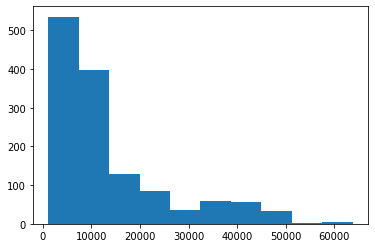

In [652]:
#Historgram Preview 
# historgram
plt.hist(df['charges'])

<AxesSubplot:>

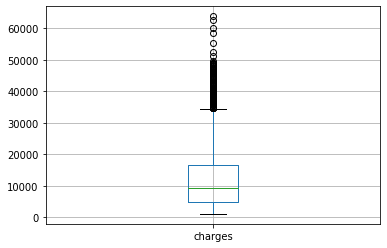

In [653]:
df.boxplot(column=['charges'])

<p> Obviously, charges has an outlier</p>
<h5> Outlier Removal</h5>

In [654]:
df2 = df.copy()


mean = df2["charges"].mean()
sigma =df2["charges"].std()
# print("Mean: {:.2f}".format(mean))
# print("Standard Deviation: {:.2f}".format(sigma))
lower_range = mean-(3*sigma)
upper_range = mean+(3*sigma)
outliers = [i for i in df2["charges"] if i<lower_range or i>upper_range]
print("Number of outliers:",len(outliers))
print("Outliers:", outliers)



Number of outliers: 7
Outliers: [51194.55914, 63770.42801, 58571.07448, 55135.40209, 52590.82939, 60021.39897, 62592.87309]


In [655]:
# Remove Rows that are Outliers
df2.drop(df2[(df2["charges"]<lower_range) | (df2["charges"]>upper_range)].index, inplace=True)

In [656]:
# Confirm the new Shape
df2.shape

(1330, 7)

In [657]:
df2.describe()

,age,bmi,children,charges
count,1330.000000,1330.000000,1330.000000,1330.000000
mean,39.200752,30.633049,1.097744,13045.345009
std,14.052396,6.091072,1.206108,11699.581595
min,18.000000,15.960000,0.000000,1121.873900
25%,26.250000,26.220000,0.000000,4724.369462
50%,39.000000,30.302500,1.000000,9303.297725
75%,51.000000,34.600000,2.000000,16389.832412
max,64.000000,53.130000,5.000000,49577.662400


<p> The Dataset is better now consdering Values from Charges</p>

<h3> Data Visualization</h3>

<p> Since much has been done on the Dataset and cleaned, visualization will help
to see the relationships among 
    Numeric Features and the target variable (Charges)</p>

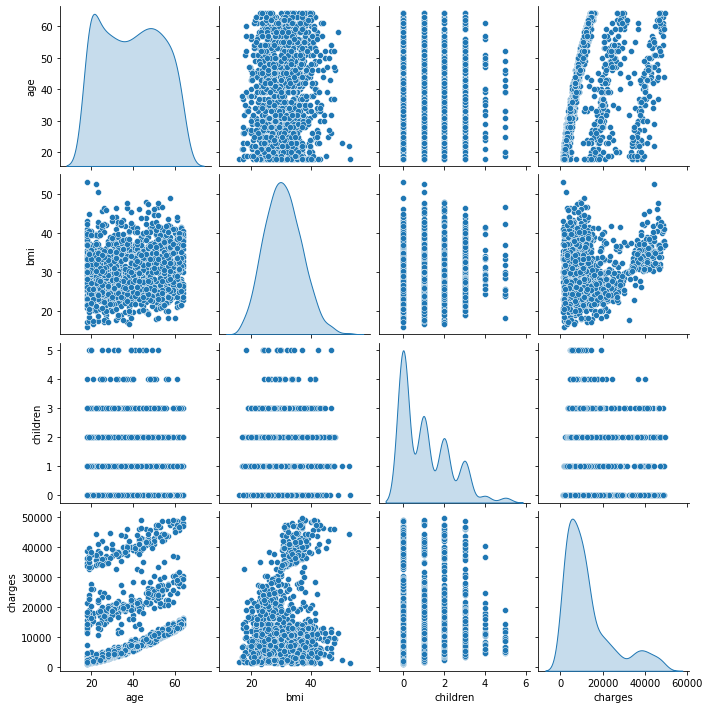

In [658]:
# Plotting the features
sns.pairplot(data=df2, diag_kind='kde')
plt.show()

<p>
<ol>
<li>Charges and bmi seem to have a fairly Normal Distribution</li>
<li>Charges and Age has some sort of a Positive Correlation - both decreasing or increasing together</li>
</ol>

</p>

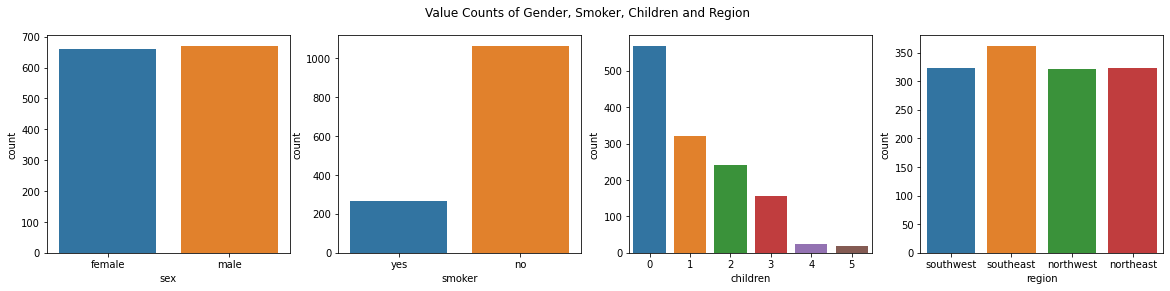

In [659]:
# Showing Counts for all categorical variables
fig, ax2 = plt.subplots(1,4,  figsize=(20,4))
fig.suptitle('Value Counts of Gender, Smoker, Children and Region')
sns.countplot(ax=ax2[0], x=df2.sex)
sns.countplot(ax=ax2[1], x=df2.smoker)
sns.countplot(ax=ax2[2], x=df2.children)
sns.countplot(ax=ax2[3], x=df2.region)
plt.show()

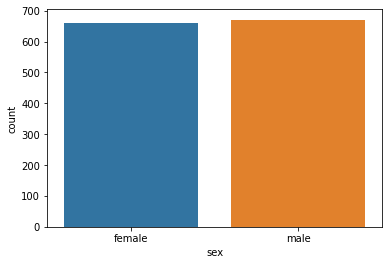

In [660]:
# Examine Some more Categorical Features
# Gender Overview
sns.countplot(df2.sex)
plt.show()

<p>There is no much difference between Males and Females Count in the dataset so it is not a major Feature</p>

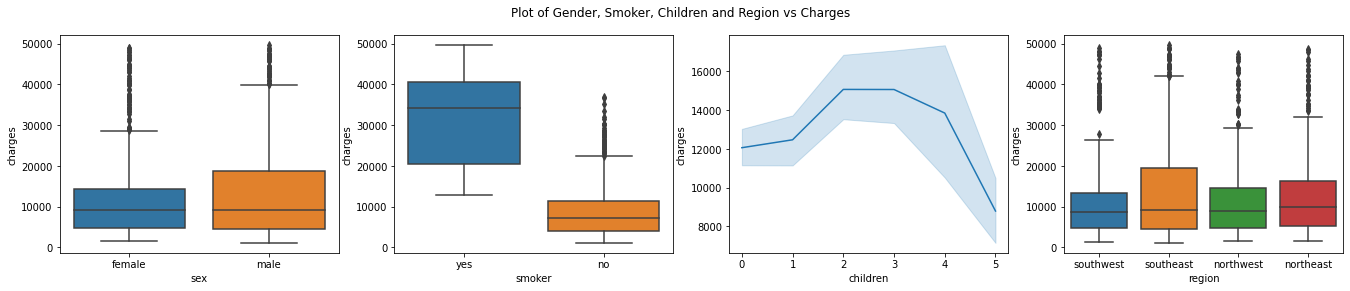

In [661]:


fig, ax2 = plt.subplots(1,4,  figsize=(23,4))
fig.suptitle('Plot of Gender, Smoker, Children and Region vs Charges',)
sns.boxplot(ax=ax2[0], x=df2.sex, y=df2.charges)
sns.boxplot(ax=ax2[1], x=df2.smoker, y=df2.charges)
sns.lineplot(ax=ax2[2], x=df2.children, y=df2.charges)
sns.boxplot(ax=ax2[3], x=df2.region, y=df2.charges)
plt.show()



<p><ol>
<li>Although no much differebce between Males and females Count but Charges are higherv with Males than Females</li>
<li>Charges are Higher with Smokers</li>
<li>People with 2-3 Children have the highestb Charges</li>
<li>Customers from Southeast seem to have a higher charge but overall it is Fair</li>
</ol></p>

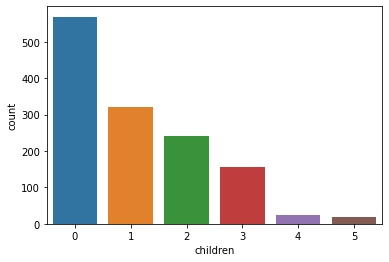

In [662]:
# Children Overview
sns.countplot(df2.children)
plt.show()

<p> Most Persons do not have Children</p>

In [663]:
# Number of Children on Charges
#sns.lineplot(df.children, df.charges)
#plt.show()

# sns.boxplot(x=df.smoker, y=df.charges)
# plt.show()
# Smokers have Higher Charges

<h4> Correlation Analysis </h4>
<p>Correlation map between charges and numeric features - age, bmi and charges</p>

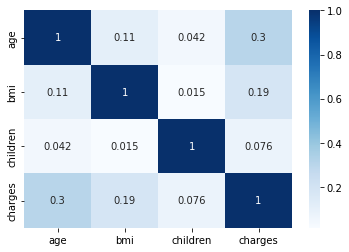

In [664]:
sns.heatmap(df2[['age', 'bmi', 'children', 'charges']].corr(), cmap='Blues', annot=True)
plt.show()

<p> Age has a strong effect or strongly corellated with Charges since its greater than 0.75<p>

<h4> Encoding and Scaling</h4>

In [665]:
# Encoding the categorical features
# Encoding the Smoker features Using pandas get_dummies

dummy =pd.get_dummies(df2['region'])
df2 = pd.concat([df2,dummy],axis=1)
df2

,age,sex,bmi,children,smoker,region,charges,northeast,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,16884.92400,0,0,0,1
1,18,male,33.770,1,no,southeast,1725.55230,0,0,1,0
2,28,male,33.000,3,no,southeast,4449.46200,0,0,1,0
3,33,male,22.705,0,no,northwest,21984.47061,0,1,0,0
4,32,male,28.880,0,no,northwest,3866.85520,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,0,1,0,0
1334,18,female,31.920,0,no,northeast,2205.98080,1,0,0,0
1335,18,female,36.850,0,no,southeast,1629.83350,0,0,1,0
1336,21,female,25.800,0,no,southwest,2007.94500,0,0,0,1


In [666]:
# Simple 1 and 0 for Sex Features
df2.sex.replace(to_replace=['male', 'female'], value=[1,0], inplace=True)

In [667]:
# Simple 1 and 0 for Smoker Features
df2.smoker.replace(to_replace=['yes', 'no'], value=[1,0], inplace=True)

In [668]:
df2

,age,sex,bmi,children,smoker,region,charges,northeast,northwest,southeast,southwest
0,19,0,27.900,0,1,southwest,16884.92400,0,0,0,1
1,18,1,33.770,1,0,southeast,1725.55230,0,0,1,0
2,28,1,33.000,3,0,southeast,4449.46200,0,0,1,0
3,33,1,22.705,0,0,northwest,21984.47061,0,1,0,0
4,32,1,28.880,0,0,northwest,3866.85520,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,northwest,10600.54830,0,1,0,0
1334,18,0,31.920,0,0,northeast,2205.98080,1,0,0,0
1335,18,0,36.850,0,0,southeast,1629.83350,0,0,1,0
1336,21,0,25.800,0,0,southwest,2007.94500,0,0,0,1


In [669]:
# Dropping the Original Region feature since its Encoded Already
df2.drop(df2[['region']],axis=1,inplace=True)

In [670]:
df2.head(4)

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0


<h5> Creating X and Y Variables -</h5>

In [671]:
X =df2[['age','bmi','smoker','children','northeast','northwest','southeast','southwest']]
Y = df2.charges.values

<p> Train and test data Set</p>

In [672]:
from sklearn.model_selection import train_test_split
X_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2)

<p> Scaling the Charges using Standard Scalar Considering the large values</p>

In [673]:
from sklearn.preprocessing import StandardScaler
numeric=['age','bmi','children']
scaled=StandardScaler()
X_train[numeric]=scaled.fit_transform(X_train[numeric])
x_test[numeric]=scaled.transform(x_test[numeric])

<h3> Applying ML Algorithms</h3>
<p>
    We will work with three Algorithms : LinearRegression, DecisionTrees and RandomForest and pick the best Regressor
    </p>

In [738]:
# SInce I hope to Compare Three Algorithms, let create a metrics Evaluation Table 
metrics=pd.DataFrame()
Model=[]
rmse=[]
mae=[]
r2=[]

In [718]:
from sklearn.linear_model import LinearRegression

In [675]:
# Initialize LinearRegression
model = LinearRegression()

In [676]:
# Training Model
model.fit(X_train,y_train)

LinearRegression()

In [741]:
# Checking for Model Accuracy on Test Data
l_predict = linearR.predict(x_test)

scr1 =r2_score(y_test, l_predict)
mean_abs1 =mean_absolute_error(y_test, l_predict)
mean_sqe1 =np.sqrt(mean_squared_error(y_test, l_predict))
# model.score(x_test,y_test)
(scr1,mean_abs1,mean_sqe1)

(0.7663545236119464, 3963.0291318674276, 5872.434415687539)

<p> Linear Regression gives us an Accuracy of 0.79 which is not bad but let check other Ml Algorithm</p>

In [743]:
from sklearn.tree import DecisionTreeRegressor

model2 = DecisionTreeRegressor(random_state=1)
model2.fit(X_train, y_train)
y_predict = model2.predict(x_test)
scr2 =r2_score(y_test, y_predict)
mean_abs2 =mean_absolute_error(y_test, y_predict)
mean_sqe2 =np.sqrt(mean_squared_error(y_test, y_predict))
#model.score(x_test,y_test)
(scr2,mean_abs2,mean_sqe2)

(0.6841590966419762, 3221.275175827068, 6827.688094268611)

<p> Accuracy is 0.68 lesser than Linear Regression</p>

<h3> Random Forest Regressor</h3>

In [744]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=120, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(x_test)

In [745]:
model.score(x_test,y_test)

0.8455126977762193

In [746]:
#Encoding the region Features
# dummy =pd.get_dummies(df2['region'])
# df2 = pd.concat([df2,dummy],axis=1)
# df2
#df2.drop(df2[['smoker']],axis=1,inplace=True)

In [684]:
# param_grid = {'n_estimators': [100, 80, 60, 55, 51, 45],  
#               'max_depth': [7, 8],
#               'max_features':['auto', 'sqrt']
#              }
# clf = GridSearchCV(RandomForestRegressor(random_state=0),param_grid,cv=5,return_train_score=False)

In [685]:
#clf.best_score_

In [686]:
rscv = RandomizedSearchCV(RandomForestRegressor(random_state=0),param_grid,cv=5,return_train_score=False,n_iter=5)
rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
                   n_iter=5,
                   param_distributions={'max_depth': [7, 8],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [100, 80, 60, 55, 51,
                                                         45]})

In [687]:
rscv.best_score_

0.8508643522595122

In [688]:
rscv.best_params_

{'n_estimators': 60, 'max_features': 'auto', 'max_depth': 7}

In [707]:
parameters = { 'max_features': ['auto', 'sqrt'],
                  "n_estimators" : sp_randInt(100, 1000),
                  "max_depth"    : sp_randInt(4, 10)
                 }

In [749]:
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters,
                               cv = 4, n_iter = 10, n_jobs=-1)
randm.fit(X_train, y_train)
# randm.best_score_

RandomizedSearchCV(cv=4,
                   estimator=RandomForestRegressor(n_estimators=120,
                                                   random_state=0),
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000210AD2ACBB0>,
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000210AD2857F0>})

In [709]:
randm.best_params_

{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 234}

In [747]:
y_pred2 = randm.predict(x_test)

In [748]:
scr3 =r2_score(y_test, y_pred2)
mean_abs3 =mean_absolute_error(y_test, y_pred2)
mean_sqe3 =np.sqrt(mean_squared_error(y_test, y_pred2))
#model.score(x_test,y_test)
(scr3,mean_abs3,mean_sqe3)

(0.86372722378014, 2380.9981629333906, 4484.809893938582)

In [750]:
#Collating Model for dataFrame Preview
Model['Linear Regression','DecisionTrees','RandomForest Regression']
rmse[mean_sqe1,mean_sqe2,mean_sqe3]
mae[mean_abs1,mean_abs2,mean_abs3]
r2[scr1,scr2,scr3]

TypeError: list indices must be integers or slices, not tuple

In [715]:
metrics['Model']=Model
metrics['rmse']=rmse
metrics['mae']=mae
metrics['r2']=r2
metrics

,Model,rmse,mae,r2
0,200,1,1,3
1,150,5,9,4
